<h1> Global Variables & Paths <h1>

In [36]:
# --------------------------------------------------------- Global Variables & Paths
# region
# @title Global Variables & Paths { display-mode: "form" }
import psutil
print(f"RAM usage at the start of the notebook is: {psutil.virtual_memory().used/1e9} GB")
import os

# --------------- vscode
VS_CODE_RAW_DATA_SET_PATH = r"C:\Users\Dell\Desktop\Bachelor\datasets\26 letters\2500\2500 balanced" # modify per data set
VS_CODE_CLEAN_DATA_SET_PATH = '../image_classification/data/clean_data'

# --------------- kaggle
KAGGLE_RAW_DATA_SET_PATH = '/kaggle/input/position-categorized-handwritten-arabic-letters' # put (dataset name immediately after /input), and any extra folders modify per data set
KAGGLE_CLEAN_DATA_SET_PATH = '/kaggle/working/clean_data'


# --------------- colab
KAGGLE_CRED_PATH = '/content/gdrive/MyDrive/Bachelor/kaggle'
KAGGLE_DATA_SET_NAME = 'mahmoudreda55/arabic-letters-numbers-ocr'  # username/dataset name..t modify per data set
COLAB_RAW_DATA_SET_PATH = '/content/kaggle_data/Dataset' # put (dataset_name) after (kaggle_data) , then put any extra folders... modify the part after (kaggle_data) per data set
COLAB_CLAEN_DATA_SET_PATH = '/content/clean_data'

# ----------------- global variables
EPOCHS = 100
DATA_PERCENTAGE_TO_USE = 100
image_size = 64
USE_RAW_DATA = True
RENAME_CLEAN_DATA = False
# ----------------- for clustering
CLUSTERS_COUNT = 5
CLUSTERS_IMAGES_DEST = os.path.join(os.getcwd(), 'clusters_images')
ESTIMATE_OPTIMAL_NO_OF_CLUSTERS = False

# print("img size: ", image_size)
print("clusters count: ", CLUSTERS_COUNT)
print('Global Variables & Paths are set successfully.')
# endregion

RAM usage at the start of the notebook is: 2.194956288 GB
clusters count:  5
Global Variables & Paths are set successfully.


<h1> time calculation function <h1>

In [37]:
# --------------------------------------------------------- time calculation function
# region
# @title time calculation function { display-mode: "form" }


import time

global_start_time = time.time() # to calculate time taken for the whole notebook to run
def calculate_and_print_time(start_time , section_name):
    end_time = time.time()
    time_taken = end_time - start_time
    hours = int(time_taken // 3600)
    minutes = int((time_taken % 3600) // 60)
    seconds = int((time_taken % 3600) % 60)
    print(f'\n{section_name} done in : {hours} h, {minutes} m, {seconds} s')

print('time calculation function is set successfully.')

time calculation function is set successfully.


<h1> install libraries <h1>

In [38]:
# --------------------------------------------------------- install libraries
# region
# @title install libraries { display-mode: "form" }



start_time = time.time()

import pkg_resources
REQUIRED_PACKAGES = ['seaborn', 'tensorflow','natsort',"psutil","pympler","arabic-reshaper","python-bidi"]

for package in REQUIRED_PACKAGES:
    try:
        dist = pkg_resources.get_distribution(package)
        print('{} ({}) is installed'.format(dist.key, dist.version))
    except pkg_resources.DistributionNotFound:
        print('{} is NOT installed'.format(package))
        %pip install {package} 
# uninstall the standalone keras package to force using the one installed with tensorflow
# %pip uninstall keras -y


calculate_and_print_time(start_time, 'installing required packages')
# print("installing required packages done")
# endregion

seaborn (0.12.2) is installed
tensorflow (2.15.0) is installed
natsort (8.4.0) is installed
psutil (5.9.3) is installed
pympler (1.0.1) is installed
arabic-reshaper (3.0.0) is installed
python-bidi (0.4.2) is installed

installing required packages done in : 0 h, 0 m, 0 s


<h1> imports <h1>

In [39]:
# --------------------------------------------------------- imports
# region
# @title imports { display-mode: "form" }
start_time = time.time()

import uuid
import time
import json
import random
import warnings
import shutil
import zipfile
from natsort import natsorted
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
# import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.preprocessing import image
from sklearn.cluster import MiniBatchKMeans
import psutil
from pympler import asizeof
import gc
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import io
import contextlib


calculate_and_print_time(start_time, 'imports')
# print("imports done")

# endregion




imports done in : 0 h, 0 m, 0 s


<h1> detect Hardware <h1>

In [40]:
# --------------------------------------------------------- detect Hardware
# region
# @title detect Hardware {display-mode: "form"}
start_time = time.time()

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
    print('TPU details: ', tpu.cluster_spec().as_dict())
except ValueError:
    tpu = None
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if(gpus):
        print("Running on ", len(gpus), " GPU(s) ")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy(devices=["GPU:{}".format(i) for i in range(len(gpus))])
    else:        
        print("Running on CPU")

print("REPLICAS: ", strategy.num_replicas_in_sync)
calculate_and_print_time(start_time,'detecting hardware')
# extra
# endregion

Running on  1  GPU(s) 
REPLICAS:  1

detecting hardware done in : 0 h, 0 m, 0 s


<h1> functions <h1>

In [41]:
# --------------------------------------------------------- functions
# region
# @title functions {display-mode: "form"}


import dis


start_time = time.time()

raw_data_path = None
clean_data_path = None

def save_clusters_images_paths(data):
    clusters_summary = {}
    clusters_images_paths = {}
    for cluster in sorted(data['cluster'].unique()):
        cluster_key = f'cluster{int(cluster)}'
        cluster_data = data[data['cluster'] == cluster]
        cluster_classes = cluster_data['label'].unique().tolist()

        clusters_summary[cluster_key] = {
            'num_classes': len(cluster_classes),
            'classes': cluster_classes,
        }
        clusters_images_paths[cluster_key] = cluster_data['filename'].tolist()

    json_data = json.dumps({'clusters_summary': clusters_summary,'clusters_images_paths': clusters_images_paths},ensure_ascii=False,indent=4)
    created_json_file_name = f'clusters_info_dataset-perc{DATA_PERCENTAGE_TO_USE}_clusters{CLUSTERS_COUNT}'
    dest_path = os.path.join(os.getcwd(), f'{created_json_file_name}.json')
    with open(dest_path, 'w',encoding='utf-8') as f:
        f.write(json_data)

# Function to transform an image into a feature vector
def image_to_feature_vector(img_path,model):
    img = image.load_img(img_path, target_size=(224, 224)) # 224 x 224 is the size of images that VGG16 previously trained on
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.reshape(-1)


def delete_from_RAM(variable_names):
    print_current_ram_usage(f"before deleting : {variable_names}")
    for var_name in variable_names:
        if var_name in globals():
            var_size_in_GB = asizeof.asizeof(globals()[var_name]) / 1e9
            print(f"variable {var_name} with size {var_size_in_GB} GB is in globals , and will be deleted")
            del globals()[var_name]
        elif var_name in locals():
            var_size_in_GB = asizeof.asizeof(locals()[var_name]) / 1e9
            print(f"variable {var_name} with size {var_size_in_GB} GB is in locals , and will be deleted")
        print()
    gc.collect()
    print(f"Deleted {variable_names} from RAM")
    print_current_ram_usage(f"after deleting : {variable_names}")


def print_current_ram_usage(message = ""):
    print(f"RAM usage {message}: {psutil.virtual_memory().used / 1e9} GB")
def get_environment():
    if 'COLAB_GPU' in os.environ:
        return 'Google Colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'Kaggle'
    elif 'VSCODE_PID' in os.environ:
        return 'VS Code'
    else:
        return 'Unknown environment'

def do_colab_staff():

    from google.colab import drive
    drive.mount('/content/gdrive')

    # storing kaggle credentials
    os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_CRED_PATH

    !kaggle datasets download -d {KAGGLE_DATA_SET_NAME}
    print("downloaded dataset" ,KAGGLE_DATA_SET_NAME )
    
    
    ! mkdir kaggle_data
    downloaded_zip_name = f"{KAGGLE_DATA_SET_NAME.split('/')[-1]}.zip" # the !kaggle datasets download command will download the zip file with the same name as the dataset name
    extract_folder_path = 'kaggle_data'
    extract_zip(downloaded_zip_name, extract_folder_path)

    global raw_data_path
    raw_data_path = COLAB_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = COLAB_CLAEN_DATA_SET_PATH


def do_kaggle_staff():
    global raw_data_path
    raw_data_path = KAGGLE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = KAGGLE_CLEAN_DATA_SET_PATH
    
def do_vscode_staff():
    global raw_data_path
    raw_data_path = VS_CODE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = VS_CODE_CLEAN_DATA_SET_PATH

def do_unknown_environment_staff():
    print("This is an unknown environment, please enter the path to the data set folder:")
    global raw_data_path
    raw_data_path = input()     

def image_is_ok(image_path):
    with warnings.catch_warnings(record=True) as w:
        try:
            img = Image.open(image_path)
            img.verify()
            if len(w) > 0:  # if any warnings were issued
                return False
            return True
        except (IOError, SyntaxError):
            return False

def copy_clean_files(dirty_dataset_path, destination_folder_path):
    print("copying clean files...")
    # If the destination directory already exists, remove it and all its contents
    if os.path.exists(destination_folder_path):
        print(f"removing {destination_folder_path} directory to create a new one...")
        shutil.rmtree(destination_folder_path)
        print(f"removed {destination_folder_path} directory to create a new one...")
    os.makedirs(destination_folder_path)
    
    # Get the total number of files for the progress bar
    total_files = sum([len(files) for r, d, files in os.walk(dirty_dataset_path)])
    
    progress_bar = tqdm(total=total_files, desc="Copying files", unit="file")
    
    for root, dirs, files in os.walk(dirty_dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            if image_is_ok(file_path):
                new_file_path = os.path.join(destination_folder_path, os.path.relpath(file_path, dirty_dataset_path))
                os.makedirs(os.path.dirname(new_file_path) , exist_ok=True)
                shutil.copyfile(file_path, new_file_path)
            else:
                print(f"file: {os.path.relpath(file_path, dirty_dataset_path)} is corrupted & skipped from dataset while copying ")
            
            progress_bar.update(1)
    
    progress_bar.close()
    print(f"copied files from {dirty_dataset_path} to {destination_folder_path} successfully") 

def rename_files(data_set_path):
    all_entities_names = natsorted(os.listdir(data_set_path))
    print("giving temporary unique names...")
    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        for filename in os.listdir(entity_path):
            temp_filename = str(uuid.uuid4()) + ".jpg"  # generate a unique filename
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, temp_filename)
            os.rename(source, destination)
    # ----------------------------------------------------------------------------------------------------
    print("renaming...")
    # then rename every file in every folder in the given path

    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        i = 1
        for filename in os.listdir(entity_path):
            entity_name = os.fsdecode(entity_name.lower())
            new_filename = entity_name + '.' + str(i) + ".jpg"
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, new_filename)
            os.rename(source, destination)
            i += 1
    print("done renaming !")


def extract_zip(source_path, destination_path):
    # delete the destination folder if it exists
    if os.path.exists(destination_path):
        print('Deleting the existing destination folder...')
        shutil.rmtree(destination_path)

    print("Extracting files...") 
    with zipfile.ZipFile(source_path, 'r') as zip_ref:
        files = zip_ref.infolist()
        for file in tqdm(files, desc="Extracting files", unit="file"):
            try:
                file.filename = file.filename.encode('cp437').decode('utf-8')  # try 'cp437' encoding first
            except UnicodeDecodeError:
                file.filename = file.filename.encode('utf-8').decode('utf-8')  # fallback to 'utf-8' if 'cp437' fails
            zip_ref.extract(file, path=destination_path)

    print("Extraction complete.")


calculate_and_print_time(start_time, 'functions')
# print("functions done")
# endregion

    


functions done in : 0 h, 0 m, 0 s


<h1> doing specific-environment things <h1>

In [42]:
# --------------------------------------------------------- doing specific-environment things
# region
# @title doing specific-environment things {display-mode: "form"}
start_time = time.time()

# test if the tpu & GPU is available

raw_data_path = None    
environment_type = get_environment() 
print(f'Environment: {environment_type}')     

print("tensowflow version:", tf.__version__)
if environment_type == 'Google Colab':
    # do_colab_staff()
    print("colab staff skipped !,doing kaggle staff instead...")
    do_kaggle_staff()
elif environment_type == 'Kaggle':
    do_kaggle_staff()
elif environment_type == 'VS Code':
    do_vscode_staff()
else:
    do_unknown_environment_staff()

print("raw data set path:", raw_data_path)
assert os.path.exists(raw_data_path), ' wrong path for data set !' 
print("clean data set path:", clean_data_path)
  
calculate_and_print_time(start_time, 'doing specific-environment things')
print_current_ram_usage()

# endregion

        


Environment: Kaggle
tensowflow version: 2.15.0
raw data set path: /kaggle/input/position-categorized-handwritten-arabic-letters
clean data set path: /kaggle/working/clean_data

doing specific-environment things done in : 0 h, 0 m, 0 s
RAM usage : 2.195030016 GB


<h1> data preparation <h1>

In [43]:
# --------------------------------------------------------- data preparation
# region
# @title data preparation {display-mode: "form"}
start_time = time.time()

print("raw data path:", raw_data_path)
if USE_RAW_DATA:
    ready_data_path = raw_data_path
    print("we will use raw data directly")
else :
    copy_clean_files(raw_data_path, clean_data_path)
    if RENAME_CLEAN_DATA:
        rename_files(clean_data_path)
    ready_data_path = clean_data_path        

# ----------------------------

print("we will use ", DATA_PERCENTAGE_TO_USE, "% of the data")
calculate_and_print_time(start_time, 'data preparation')
print_current_ram_usage()

# endregion
        


raw data path: /kaggle/input/position-categorized-handwritten-arabic-letters
we will use raw data directly
we will use  100 % of the data

data preparation done in : 0 h, 0 m, 0 s
RAM usage : 2.19500544 GB


<h1 > 1 - Loading Images in a Dataframe <h1>

In [44]:
# 1 --------------------------------------------------------- Loading Images in a Dataframe
# region
# @title 1 - Loading Images in a Dataframe { display-mode: "form" }


from matplotlib.style import available


start_time = time.time()

all_entities_names = natsorted(os.listdir(ready_data_path))
print("all entities names:", all_entities_names)
filenames = []
original_data_set_size = 0
feature_extraction_model = VGG16(weights='imagenet', include_top=False)

all_feature_vectors = []

for entity_name in all_entities_names:
    print(f"loading ({entity_name}) images in the dataframe")
    entity_path = os.path.join(ready_data_path, entity_name)
    entity_filenames = [file_name for file_name in os.listdir(entity_path)]
    original_data_set_size += len(entity_filenames)
    random.shuffle(entity_filenames)
    entity_filenames = entity_filenames[:int(len(entity_filenames) * (DATA_PERCENTAGE_TO_USE / 100))]
    filenames.extend([os.path.join(entity_name, file_name) for file_name in entity_filenames])

    # Initialize feature_vectors array for current entity
    feature_vectors = np.empty((len(entity_filenames), 25088))
    
    print(f"extracting features from ({entity_name}) images...")
    trash_printings = io.StringIO()
    with contextlib.redirect_stdout(trash_printings): # just to suppress the output of the following code
        for i, entity_file_name in enumerate(entity_filenames):
            img_path = os.path.join(entity_path, entity_file_name)
            feature_vectors[i] = image_to_feature_vector(img_path, feature_extraction_model)
    all_feature_vectors.append(feature_vectors)

# Combine all feature vectors into one array
all_feature_vectors = np.concatenate(all_feature_vectors)


print_current_ram_usage("after making the flattened_images np array")

print(f"selected data set size = {DATA_PERCENTAGE_TO_USE / 100} * {original_data_set_size} = {len(filenames)}") 
file_labels = [x.split(os.sep)[0] for x in filenames] 
data = pd.DataFrame({"filename": filenames, "label": file_labels})
data = data.iloc[natsorted(data.index.values)] # sort the data frame by the labels using natsort

# clustering part ------------------------------------------------------------

# -------------------- Elbow Method to find the optimal number of clusters
# if ESTIMATE_OPTIMAL_NO_OF_CLUSTERS:
#     print("Elbow Method to find the optimal number of clusters...")
#     wcss = []
#     for i in range(1, 11):  # change the range according to your needs
#         kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#         kmeans.fit(flattened_images)
#         wcss.append(kmeans.inertia_)
#     plt.plot(range(1, 11), wcss)
#     plt.title('Elbow Method')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
#     plt.show()
#     print_current_ram_usage("after Elbow Method to find the optimal number of clusters")
# -------------------------------------
# this model is used to extract features from the images , to cluster them properly

# Perform KMeans clustering
("performing KMeans clustering...")

batch_size = len(all_feature_vectors) // 50
print(f"batch_size = {len(all_feature_vectors)} // 50 = {batch_size}")

# Get the cluster labels for each image
labels = MiniBatchKMeans(n_clusters=CLUSTERS_COUNT, random_state=0, batch_size=batch_size).fit(all_feature_vectors).labels_

delete_from_RAM(["all_feature_vectors"])
data['cluster'] = labels


calculate_and_print_time(start_time, 'Loading Images in a Dataframe')
# endregion



all entities names: ['ء_معزول', 'أ-همزة-سفلية_معزول', 'أ-همزة-سفلية_نهاية', 'أ-همزة-علوية_معزول', 'أ-همزة-علوية_نهاية', 'أ_معزول', 'أ_نهاية', 'ب_بداية', 'ب_معزول', 'ب_نهاية', 'ب_وسط', 'ت_بداية', 'ت_معزول', 'ت_نهاية', 'ت_وسط', 'ث_بداية', 'ث_معزول', 'ث_نهاية', 'ث_وسط', 'ج_بداية', 'ج_معزول', 'ج_نهاية', 'ح_بداية', 'ح_معزول', 'ح_نهاية', 'خ_بداية', 'خ_معزول', 'خ_نهاية', 'د_معزول', 'د_نهاية', 'ذ_معزول', 'ذ_نهاية', 'ر_معزول', 'ر_نهاية', 'ز_معزول', 'ز_نهاية', 'س_بداية', 'س_معزول', 'س_نهاية', 'س_وسط', 'ش_بداية', 'ش_معزول', 'ش_نهاية', 'ش_وسط', 'ص_بداية', 'ص_معزول', 'ص_نهاية', 'ص_وسط', 'ض_بداية', 'ض_معزول', 'ض_نهاية', 'ض_وسط', 'ط_معزول', 'ط_وسط', 'ظ_معزول', 'ظ_وسط', 'ع_بداية', 'ع_معزول', 'ع_نهاية', 'ع_وسط', 'غ_معزول', 'غ_نهاية', 'غ_وسط', 'ف_بداية', 'ف_معزول', 'ف_نهاية', 'ف_وسط', 'ق_بداية', 'ق_معزول', 'ق_نهاية', 'ق_وسط', 'ك_بداية', 'ك_معزول', 'ك_نهاية', 'ك_وسط', 'ل_بداية', 'ل_معزول', 'ل_نهاية', 'ل_وسط', 'لا-مد_معزول', 'لا-همزة_معزول', 'لا-همزة_نهاية', 'لا_مد_نهاية', 'لا_معزول', 'لا_نهاية', 'م_بداية

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RAM usage before deleting : ['all_feature_vectors']: 11.366842368 GB
variable all_feature_vectors with size 9.095905424 GB is in globals , and will be deleted

Deleted ['all_feature_vectors'] from RAM
RAM usage after deleting : ['all_feature_vectors']: 2.258378752 GB

Loading Images in a Dataframe done in : 0 h, 50 m, 10 s


<h1>Vislalizing clusters <h1>

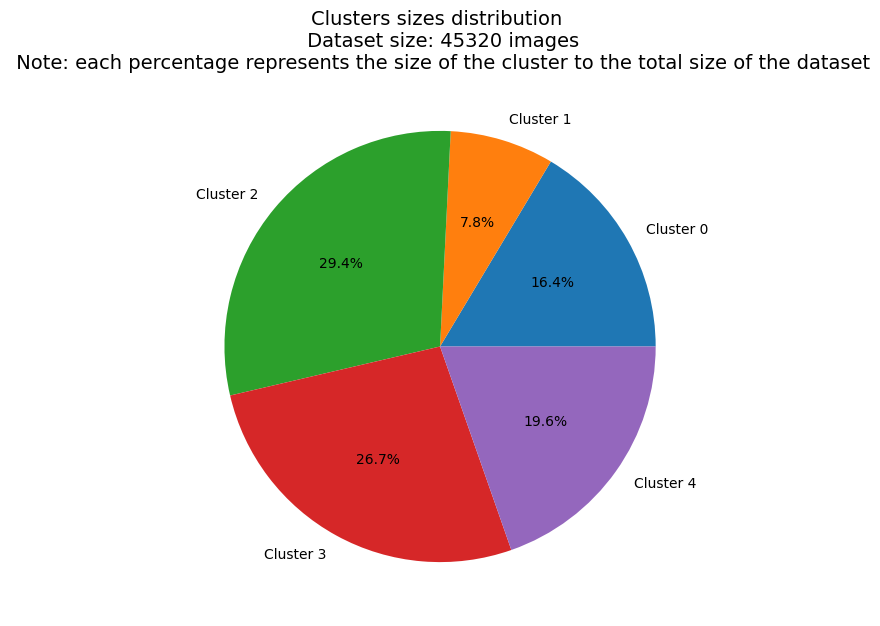

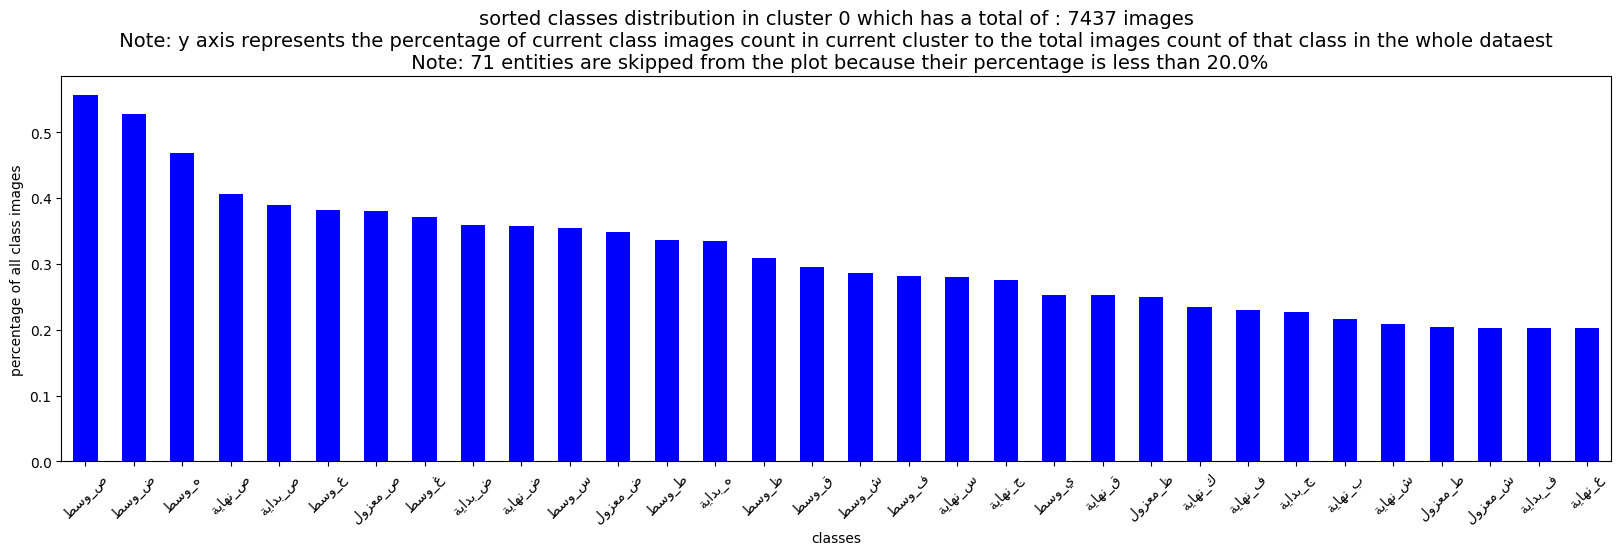

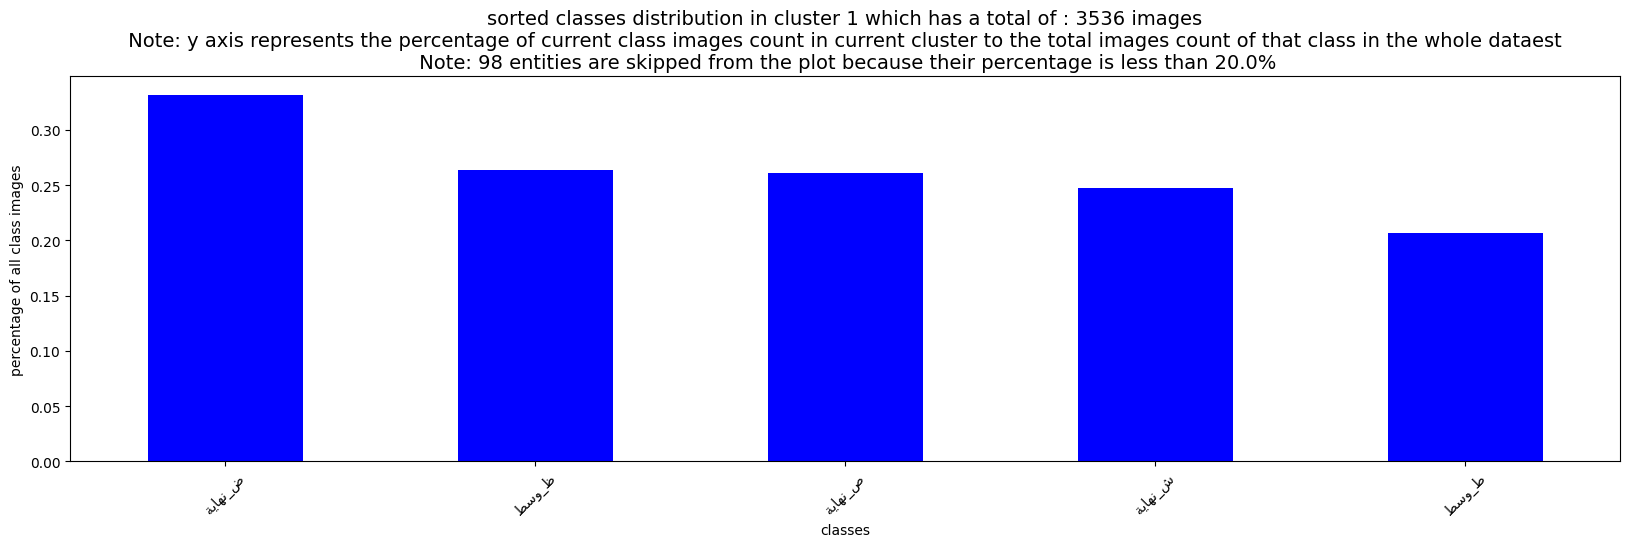

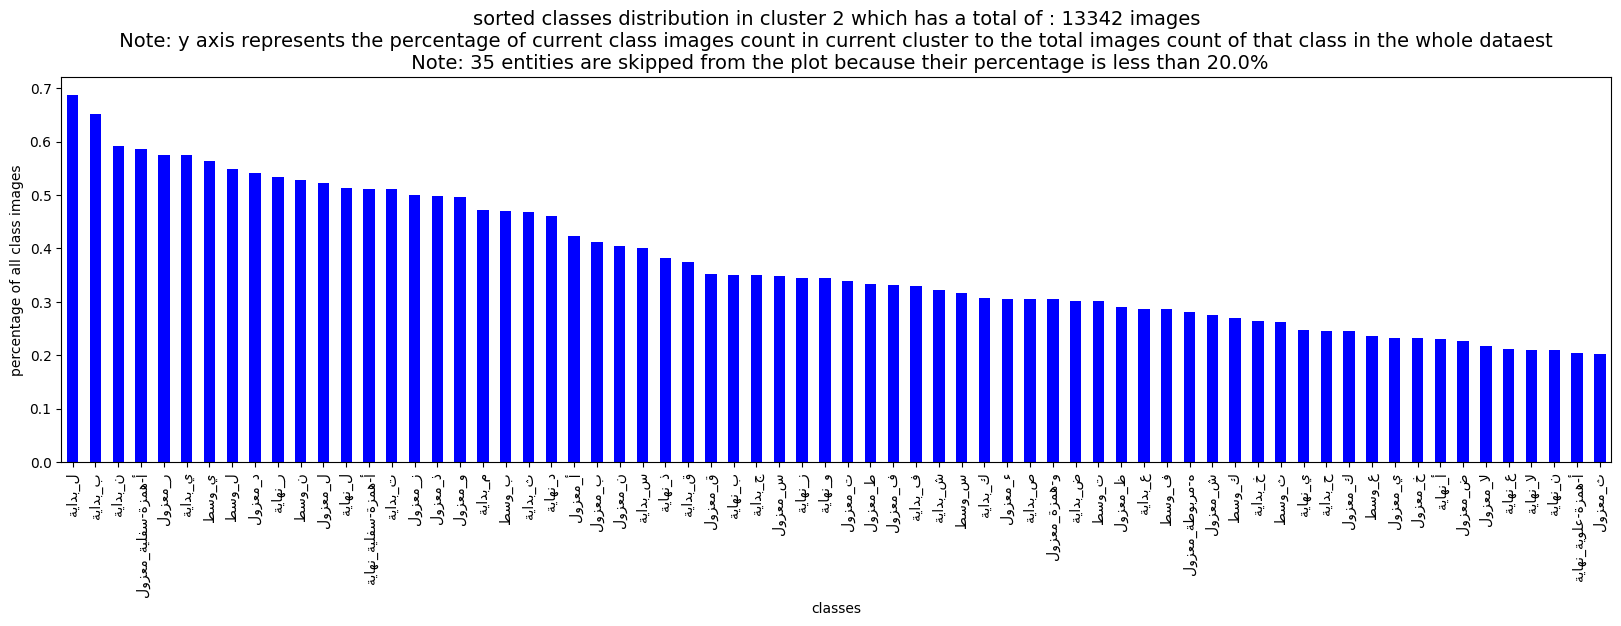

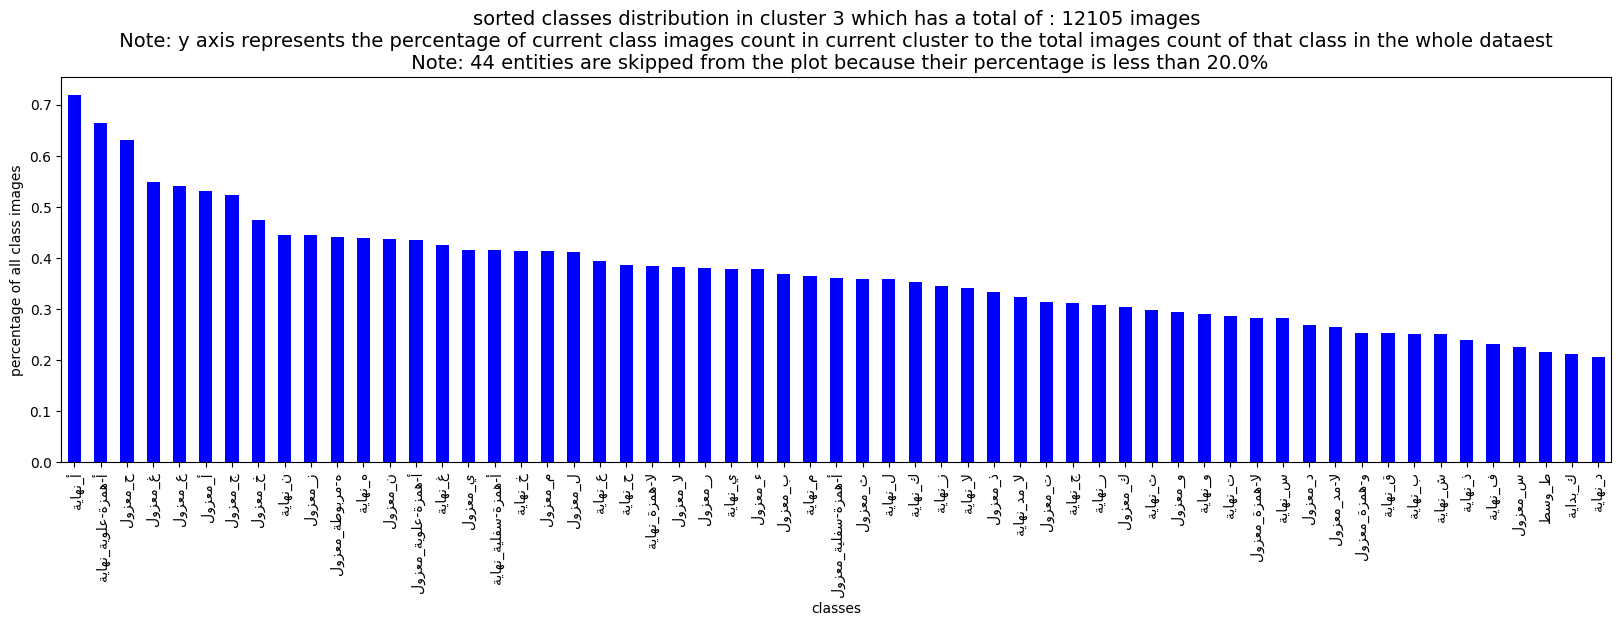

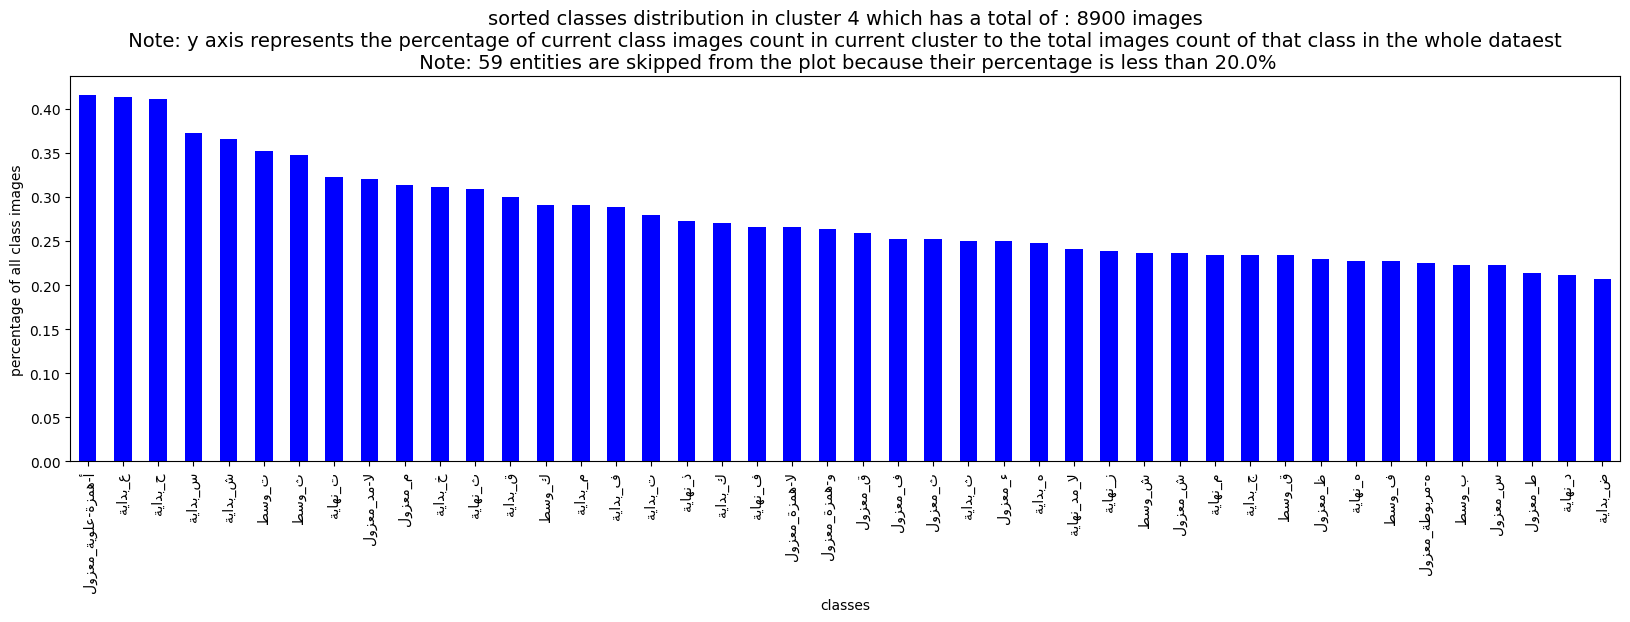

In [47]:
# 2 --------------------------------------------------------- Visualizing Clusters
# region
# @title 2 - Visualizing Clusters { display-mode: "form" }

import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

plt.rcParams['font.family'] = 'Arial'

def display_entities_distribution_in_each_cluster(data, sort_plot=False):
    crosstab = pd.crosstab(data['cluster'], data['label'])
    all_classes_total_counts = data['label'].value_counts()  # Total count of each entity in the dataset

    for cluster_index in crosstab.index:
        cluster_data = crosstab.loc[cluster_index]
        cluster_size = sum(cluster_data)
        cluster_data /= all_classes_total_counts  # Normalize the count of each entity by the total count of that entity in the dataset
        # remove the extities which percentages is less than 10% to make the plot more clear , but first get the number of such entities
        skipping_threshhold = 1 / CLUSTERS_COUNT
        num_of_skipped_entities = len(cluster_data[cluster_data <= skipping_threshhold])
        cluster_data = cluster_data[cluster_data > skipping_threshhold]
        if sort_plot:
            cluster_data = cluster_data.sort_values(ascending=False)
        ax = cluster_data.plot(kind='bar', color='blue', figsize=(20,5))  # Increase figure size and decrease bar width
        title_text = f'{"sorted " if sort_plot else " "}classes distribution in cluster {cluster_index} which has a total of : {cluster_size} images'
        title_text += f'\n Note: y axis represents the percentage of current class images count in current cluster to the total images count of that class in the whole dataest '
        # add the number of skipped entities to the title
        title_text += f'\n Note: {num_of_skipped_entities} entities are skipped from the plot because their percentage is less than {skipping_threshhold * 100}%'
        plt.title(title_text, fontsize=14)
        plt.xlabel('classes')
        plt.ylabel('percentage of all class images')
        
        labels = [get_display(arabic_reshaper.reshape(label.get_text())) for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        # only rotate if number of classes is less than or equal to 32
        rotation_threshold = 32
        if len(labels) <= rotation_threshold:
            plt.xticks(rotation=45)
        plt.show()
def visualize_clusters(data):
    crosstab = pd.crosstab(data['cluster'], data['label'])
    # Calculate the total number of images in each cluster
    total_images_per_cluster = crosstab.sum(axis=1)

    # pie chart ----------------------------------------
    plt.figure(figsize=(20, 7))
    chart_lables = ['Cluster ' + str(i) for i in total_images_per_cluster.index]
    plt.pie(total_images_per_cluster.values, labels=chart_lables, autopct='%1.1f%%')
    plt_title = f'Clusters sizes distribution \n Dataset size: {len(data)} images'
    plt_title += f'\n Note: each percentage represents the size of the cluster to the total size of the dataset'
    plt.title(plt_title, fontsize=14)
    plt.show()
    # --------------------------------------------------
    # For each cluster, plot a histogram of the count of every entity
    # display_entities_distribution_in_each_cluster(data)
    display_entities_distribution_in_each_cluster(data,sort_plot=True)

visualize_clusters(data)
save_clusters_images_paths(data)

<h1>Total Execution Time <h1>

In [46]:
# 15 --------------------------------------------------------- Execution Time
# region
# @title 15 - Execution time  { display-mode: "form" }

calculate_and_print_time(global_start_time , 'Whole notebook execution time')





Whole notebook execution time done in : 0 h, 50 m, 14 s
